In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
import seaborn as sns



In [2]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp12.csv')

In [3]:
pbp.columns

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'OffenseTeam', 'DefenseTeam', 'side_of_field',
       'yardline_100', 'date', 'quarter_seconds_remaining',
       'half_seconds_remaining', 'game_seconds_remaining', 'game_half',
       'drive', 'Quarter', 'Down', 'YardsToGo', 'Description', 'play_type',
       'yards_gained', 'Offteam_score', 'defteam_score', 'score_differential',
       'season', 'series', 'stadium', 'play_type_nfl', 'drive_play_count',
       'drive_time_of_possession', 'roof', 'surface_type', 'num_plays',
       'num_injuries', 'Avg_Temp', 'Avg_Percipitation_Prob_Percent',
       'HOME_day_since_last_game', 'AWAY_day_since_last_game',
       'total_play_count', 'home_team_on_offense', 'home_team_on_defense',
       'offense_formation', 'defenders_in_box', 'pass_count', 'run_count',
       'Previous_DEF_rank', 'current_defence_rank', 'Player-Injured-On-Play',
       'Temperature', 'Precipitation', 'temperature_grade',

In [ ]:
# List of categorical columns
categorical_cols = [
    'OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field', 'stadium', 
    'play_type_nfl', 'roof', 'surface_type', 'home_team', 'away_team', 
    'season_type', 'offense_formation', 'temperature_grade', 'temperature_bucket'
]

# Dictionary to hold LabelEncoders for each column
label_encoders = {}

# Apply LabelEncoder to each categorical column and store encoders
for col in categorical_cols:
    le = LabelEncoder()
    pbp[col] = le.fit_transform(pbp[col].astype(str))  # Ensure the column is treated as a string
    label_encoders[col] = le 

In [5]:
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
               'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation', 'goal_line_situation',
               'pass_count', 'run_count', 'current_defence_rank','temperature_grade', 'epa', 
               'late_season','is_close_game', 'poor_field_condition', 'rest_differential', 'blitz_situation',
               'short_rest','pass_run_ratio', 'offensive_predictability', 'fourth_down_attempt', 'third_and_long']]


y = pbp['Player-Injured-On-Play']

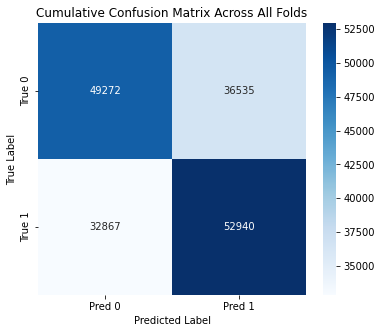

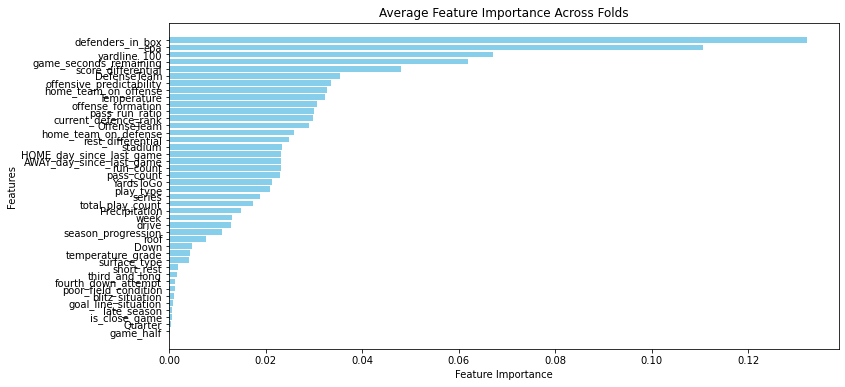

Accuracy scores for each fold: [0.609017912291538, 0.7106238418777023, 0.49876466954910437, 0.5123533045089561, 0.5799876466954911, 0.5410747374922792, 0.6111797405806053, 0.5694873378628783, 0.57041383570105, 0.6704756022235948, 0.650401482396541, 0.6059295861642989, 0.5756639901173564, 0.5281037677578753, 0.5694873378628783, 0.5873996294008648, 0.6019147621988882, 0.5305744286596664, 0.7041383570105003, 0.5009264978381717, 0.5917232859789994, 0.5735021618282891, 0.5386040765904879, 0.6439159975293391, 0.6392835083384806, 0.5957381099444101, 0.5231624459542927, 0.5969734403953058, 0.5843113032736257, 0.6241507103150092, 0.6488573193329216, 0.6349598517603459, 0.6016059295861643, 0.6071649166151946, 0.5969734403953058, 0.6664607782581841, 0.618591723285979, 0.6800494132180358, 0.6852995676343422, 0.5555898702903026, 0.5386040765904879, 0.6334156886967264, 0.6275478690549722, 0.5315009264978382, 0.5784434836318715, 0.6198270537368746, 0.5506485484867202, 0.650710315009265, 0.66862260654

In [ ]:
# Initialize cumulative confusion matrix
cumulative_cm = np.zeros((2, 2), dtype=int)

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = [] 
auc_scores = []
feature_importances = np.zeros(X.shape[1])

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train Gradient Boosting model
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = gb_model.predict(X_test_resampled)
    y_pred_prob = gb_model.predict_proba(X_test_resampled)[:, 1]

    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    auc = roc_auc_score(y_test_resampled, y_pred_prob)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    auc_scores.append(auc)

    # Store feature importances
    feature_importances += gb_model.feature_importances_

    # Update cumulative confusion matrix
    cm = confusion_matrix(y_test_resampled, y_pred)
    cumulative_cm += cm  # Add fold's confusion matrix to cumulative

# Plot the cumulative confusion matrix
plt.figure(figsize=(6, 5), facecolor='white')
sns.heatmap(cumulative_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cumulative Confusion Matrix Across All Folds')
plt.show()

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

print(f'AUC scores for each fold: {auc_scores}')
print(f'Mean AUC: {np.mean(auc_scores):.4f}')
print(f'Standard Deviation: {np.std(auc_scores):.4f}')